# Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image for binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip

## Define Image procesing() class

In [2]:
class Image_processing:
    def __init__(self, test_img_filenames, chessboard_size, lane_shape):
        """
        Handle camera calibration, distortion correction, perspective warping.
        Handle the proces of creating thresholded binary image with gradients and color transforms. 
        
        :param test_img_filenames: list of file names of the chessboard calibration images.
        :param chessboard_size: the numbers of inseide corners in (x, y)
        :param lane_shape: source points of region of interest (ROI)
        """
        # Get image size
        example_img = cv2.imread(test_img_filenames[0])
        self.img_size = example_img.shape[0:2]
        self.img_height = self.img_size[0]
        self.img_width = self.img_size[1]
        
        
        # Calibration
        self.mtx, self.dist = self.calibration(test_img_filenames,chessboard_size)
        
        # Define bird-eye view transform and its inverse
        top_left, top_right, bottom_left, bottom_right = lane_shape
        self.src = np.float32([top_left, top_right, bottom_right, bottom_left])
        self.dst = np.float32([[self.img_width/4,0], [self.img_width*3/4,0],
                               [self.img_width*3/4,self.img_height-1], [self.img_width/4, self.img_height-1]])
        
        # Get transform matrix and its inverse
        self.bird_view_transform = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_bird_view_transform = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def calibration(self, test_img_filenames, chessboard_size):
        """
        Calibrate the camera using chessboard calibration images.        
        """
        chess_rows, chess_cols = chessboard_size
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((chess_rows*chess_cols,3), np.float32)
        objp[:,:2] = np.mgrid[0:chess_cols,0:chess_rows].T.reshape(-1,2)
        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.
        
        # Step through the list and search for chessboard corners
        for fname in test_img_filenames:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (chess_cols,chess_rows),None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
                
        # Camera calibration, given object points, image points, and the shape of the grayscale image
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        if not ret:
            raise Exception("Camera calibration unsuccessful.")
        return mtx, dist
    
    def undistort(self,image):
        """
        Undistort camera's raw image
        
        :param image: orignial image
        """
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    
    def birds_eye(self, undistorted_img):
        """
        Apply a perspective transform to rectify binary image
        
        :param undistorted_img: undistorted image
        """
        return cv2.warpPerspective(undistorted_img, self.bird_view_transform, 
                                   (self.img_width, self.img_height), flags=cv2.INTER_LINEAR)
    
    def inverse_birds_eye(self, bird_view_img):
        """
        Apply a perspective transform to rectify binary image
        
        :param bird_view_img: perspective transformed bird-view image
        """
        return cv2.warpPerspective(bird_view_img, self.inverse_bird_view_transform, 
                                   (self.img_width, self.img_height), flags=cv2.INTER_LINEAR)

    def score_pixles(img) -> np.ndarray:
        """
        Create thresholded binary image with gradients and color transforms:
            Gradient taken in x direction
            Gradient taken in y direction
            Magnitude of the gradient
            S channel of HLS color space
            B channel of LAB color space
            V channel of HSV color space
            L channel of HLS color space
            
        :param img: bird-view image in BGR.
        """
        setting = [{'name': 'Sobel_x', 'cspace':'GRAY', 'channel': 'x', 'clipLimit': 2.0, 'threshold': 50},
                   {'name': 'Sobel_y', 'cspace':'GRAY', 'channel': 'y', 'clipLimit': 2.0, 'threshold': 50},
                   {'name': 'Sobel_mag', 'cspace':'GRAY', 'channel': 'mag', 'clipLimit': 2.0, 'threshold': 50},
                   {'name': 'hls_s', 'cspace':'HLS', 'channel': 2, 'clipLimit': 2.0, 'threshold': 150},
                   {'name': 'lab_b', 'cspace':'LAB', 'channel': 2, 'clipLimit': 2.0, 'threshold': 150},
                   {'name': 'hsv_v', 'cspace':'HSV', 'channel': 2, 'clipLimit': 16.0, 'threshold': 200},
                   {'name': 'hls_l', 'cspace':'HLS', 'channel': 1, 'clipLimit': 2.0, 'threshold': 200}]
        
        result = np.zeros(img.shape[0:2]).astype('uint8')
        for params in setting:
            # Change color space
            color_t = getattr(cv2, 'COLOR_BGR2{}'.format(params['cspace']))
            if params['cspace'] == 'GRAY':
                gray = cv2.cvtColor(img, color_t)
                if params['channel'] == 'x':
                    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
                    gray = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
                elif params['channel'] == 'y':
                    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
                    gray = np.uint8(255*abs_sobely/np.max(abs_sobely))
                else:
                    abs_sobelxy = np.sqrt(abs_sobelx ** 2 + abs_sobely **2)
                    gray = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
            else:
                gray = cv2.cvtColor(img, color_t)[:,:,params['channel']]
            
            # Normalize regions of the image using CLAHE
            clahe = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8, 8))
            norm_img = clahe.apply(gray)
            
            # Threshold to binary
            ret, binary = cv2.threshold(norm_img, params['threshold'], 1, cv2.THRESH_BINARY)
            result += binary

        binary_result = np.zeros(img.shape[0:2]).astype('uint8')
        binary_result[(result > 1)] = 1
        return binary_result, result

## Define Line() class

In [3]:
class Line:
    """    
    Handle line track process
    Calculate the curvature
    Calculate the position from center
    """
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # radius of curvature of the line in some units
        self.curvature = None 
        
        # 2nd order polynomial coefficients of each lane
        self.left_fit = [np.array([False])] 
        self.right_fit = [np.array([False])] 
        
        # Tolerance of the change of 2nd order coefficient 
        self.tolerance = 0.1
        
        # Initiate deque for smoothing the measurement over the last 'fit_count' frames of video
        self.fit_count = 20
        self.left_fit_count = 0
        self.right_fit_count = 0
        self.left_fit_deque = deque(self.fit_count*[np.array([False])],self.fit_count)
        self.right_fit_deque = deque(self.fit_count*[np.array([False])],self.fit_count)
        
        # Define constants
        self.y_eval = 700
        self.midx = 640
        self.ym_per_pix = 30./720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension

        
    def update_fits(self, left_fit, right_fit):
        """
        Define a deque for smoothing the measurement over the last 'fit_count' frames of video
        
        :param left_fit: 2nd order polynomial coefficients of left lane
        :param right_fit: 2nd order polynomial coefficients of right lane
        """
        if self.detected:
            # The difference of 2nd order coefficient 
            left_error = np.abs(self.left_fit[0] - left_fit[0])
            right_error = np.abs(self.right_fit[0] - right_fit[0])
            
            """
            If the difference is less than tolerance, 
                append it the deque of measurement
            else
                abandon it
            """
            if left_error < self.tolerance:
                self.left_fit_deque.pop()
                self.left_fit_deque.appendleft(left_fit)
                self.left_fit_count += 1
                self.left_fit = np.mean(list(self.left_fit_deque)[:self.left_fit_count],axis=0)
                # Update the curvature
                self.update_curvature(self.left_fit)
            if right_error < self.tolerance:
                self.right_fit_deque.pop()
                self.right_fit_deque.appendleft(right_fit)   
                self.right_fit_count += 1
                self.right_fit = np.mean(list(self.right_fit_deque)[:self.right_fit_count],axis=0)   
        else:
            # Initiate the deque of measurement
            self.left_fit_deque.pop()
            self.left_fit_deque.appendleft(left_fit)
            self.left_fit_count += 1
            self.right_fit_deque.pop()
            self.right_fit_deque.appendleft(right_fit)
            self.right_fit_count += 1            
            self.right_fit = right_fit
            self.left_fit = left_fit             
            # Update the curvature
            self.update_curvature(self.left_fit)
            self.detected = True
        
    def update_curvature(self,fit):
        """
        Update radius of curvature
        """
        ploty = np.linspace(0, self.y_eval-1, self.y_eval)
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        fit_cr = np.polyfit(ploty*self.ym_per_pix, fitx*self.xm_per_pix, 2)
        curvature = ((1 + (2*fit_cr[0]*self.y_eval*self.ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        
        if not self.detected:
            self.curvature = curvature        
        else:
            self.curvature = 0.25 * self.curvature + 0.75 * curvature 
            
    def get_position_from_center(self):
        """
        Get the position from center
        """
        x_left_pix = self.left_fit[0]*(self.y_eval**2) + self.left_fit[1]*self.y_eval + self.left_fit[2]
        x_right_pix = self.right_fit[0]*(self.y_eval**2) + self.right_fit[1]*self.y_eval + self.right_fit[2]
        
        return ((x_left_pix + x_right_pix)/2.0 - self.midx) * self.xm_per_pix

## Define Process_image() class

In [4]:
def Process_image(image):
    """
    Handle the process of finding both left and right lanes based on image.
    Generate plots to demostrate the results of land finding. 
    
    :param image: original image from camera
    """
    # Generate bird-view binary image from original image
    binary_warped, _ = Image_processing.score_pixles(camera.birds_eye(image))
    
    # Set the width of the windows +/- margin
    margin = 40
    
    if not line.detected:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set minimum number of pixels found to recenter window
        minpix_score = 300
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels score, recenter next window on their mean position
            if len(good_left_inds) > minpix_score:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix_score:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        line.update_fits(left_fit, right_fit)
        
    else:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_fit = line.left_fit    
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_fit = line.right_fit
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        line.update_fits(left_fit, right_fit)
        left_fit = line.left_fit 
        right_fit = line.right_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
        
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, camera.inverse_bird_view_transform, (camera.img_size[1], camera.img_size[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    # Add Radius of Curvature
    cv2.putText(result,'Radius of Curvature: %5.2fm' % \
                line.curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    # Add distance from center
    position_from_center = line.get_position_from_center()
    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % \
                (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
    return result

## Calibrate camera with calibration images

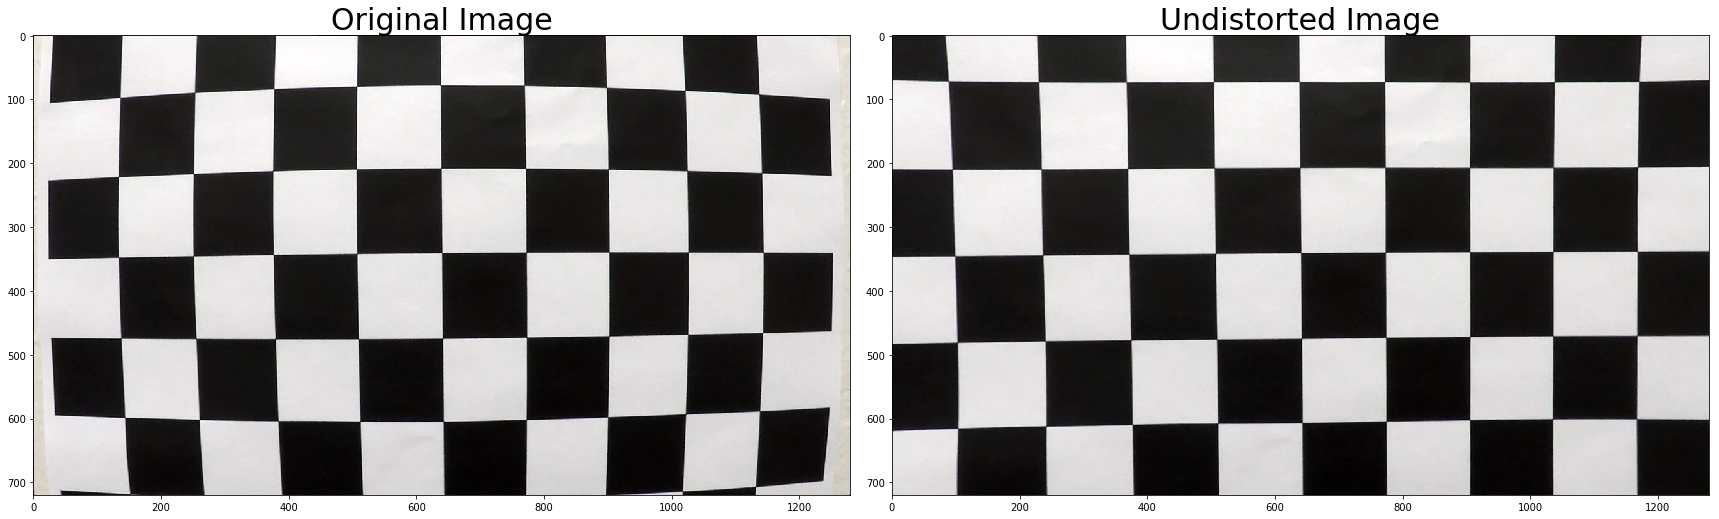

In [5]:
# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
lane_shape = [(584, 458), (701, 458), (295, 665), (1022, 665)]
camera = Image_processing(images, chessboard_size=(9, 6), lane_shape=lane_shape)

# Apply a distortion correction to a raw image
img = cv2.imread('../camera_cal/calibration1.jpg')
dst = camera.undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image',fontsize = 30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image',fontsize = 30)
plt.show()

## Pipeline (single images)

### 1. Provide an example of a distortion-corrected image

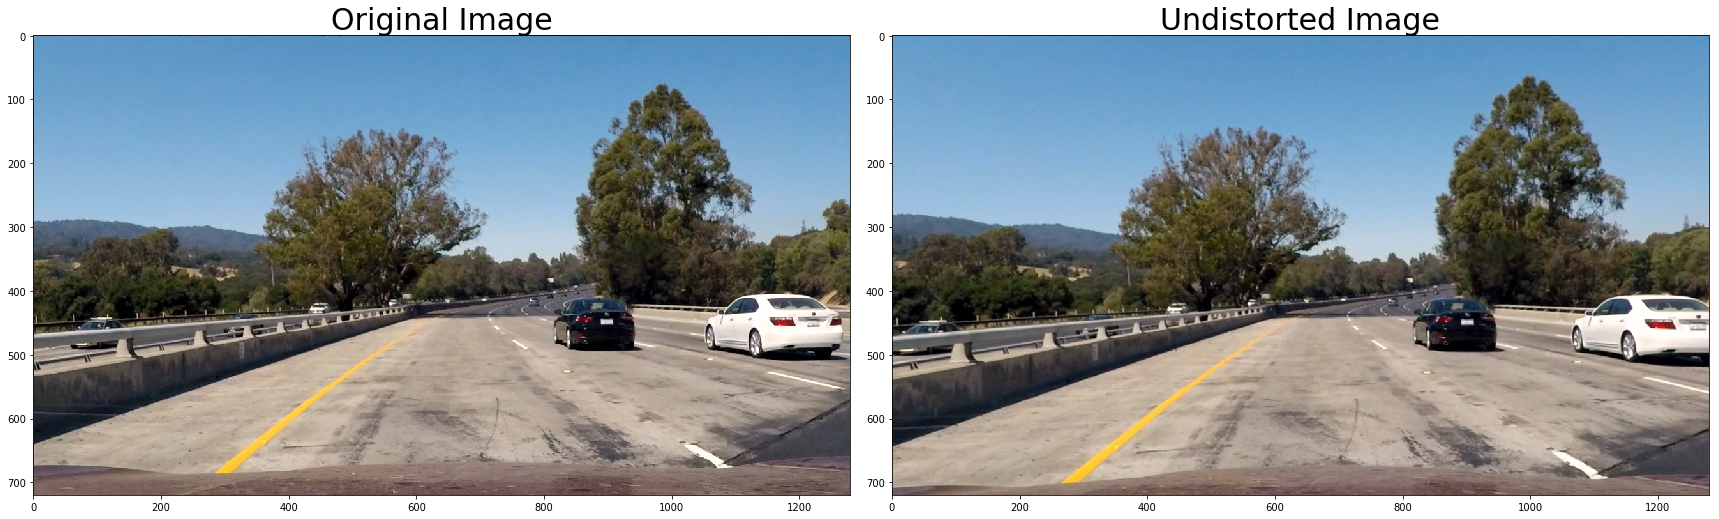

In [6]:
img = cv2.imread('../test_images/test1.jpg')
result = camera.undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image',fontsize = 30)
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image',fontsize = 30)
plt.show()

### 2. Perform a perspective transform and provide an example of a transformed image.

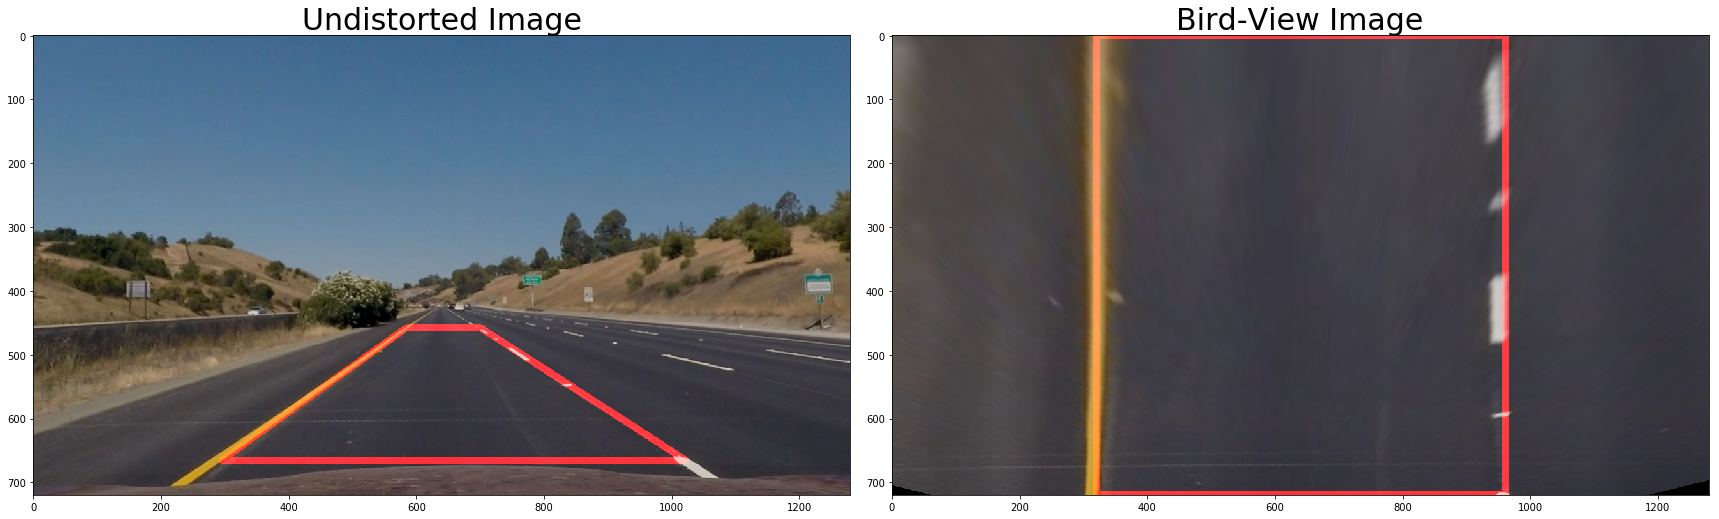

In [7]:
def draw_quadrilateral(img, vertices, color=[0, 0, 255], thickness=10):
    """
    Plot a quadrilateral with the four vertices from input vertices
    """
    line_img = np.zeros_like(img)
    A, B, C, D = [tuple(x) for x in vertices]
    cv2.line(line_img, A, B, color, thickness)
    cv2.line(line_img, B, C, color, thickness)
    cv2.line(line_img, C, D, color, thickness)
    cv2.line(line_img, D, A, color, thickness)
    return line_img

# Load an input image
img = cv2.imread('../test_images/straight_lines1.jpg')
# Perform distortion correction
undist = camera.undistort(img)
birds_eye = camera.birds_eye(undist)

dst_lines = draw_quadrilateral(birds_eye, camera.dst)
src_lines = draw_quadrilateral(undist, camera.src)

src_img = cv2.addWeighted(undist, 0.8, src_lines, 1., 0.)
dst_result = cv2.addWeighted(birds_eye, 0.8, dst_lines, 1., 0.) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image',fontsize = 30)
ax2.imshow(cv2.cvtColor(dst_result, cv2.COLOR_BGR2RGB))
ax2.set_title('Bird-View Image',fontsize = 30)
plt.show()

### 3. Provide an example of a binary image result.

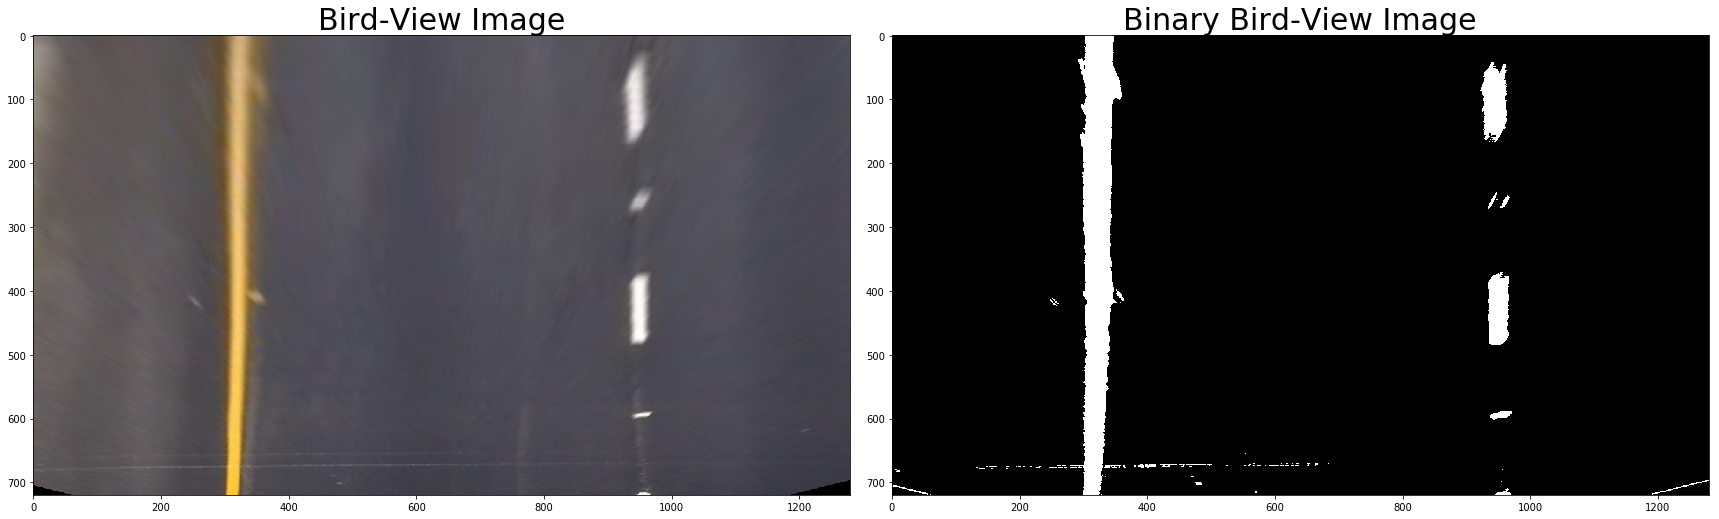

In [8]:
img = cv2.imread('../test_images/straight_lines1.jpg')
birds_eye = camera.birds_eye(camera.undistort(img))

binary_birds_eye, _ = Image_processing.score_pixles(birds_eye)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(birds_eye, cv2.COLOR_BGR2RGB))
ax1.set_title('Bird-View Image',fontsize = 30)
ax2.imshow(binary_birds_eye, cmap = 'gray')
ax2.set_title('Binary Bird-View Image',fontsize = 30)
plt.show()

### 6. Provide an example image of your result plotted back down onto the road.

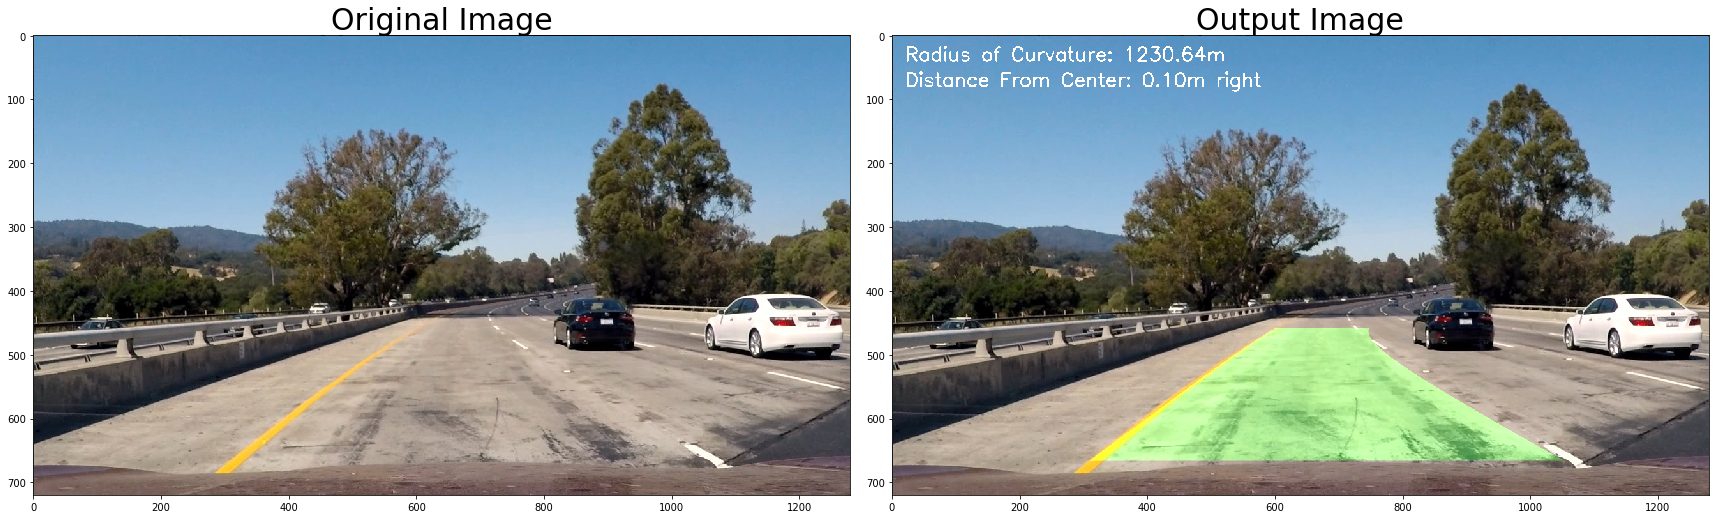

In [9]:
img = cv2.imread('../test_images/test1.jpg')
line = Line()
result = Process_image(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image',fontsize = 30)
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax2.set_title('Output Image',fontsize = 30)
plt.show()

# Pipeline (video)

In [10]:
output = '../test_videos_output/project_video.mp4'
line = Line()
clip = VideoFileClip("../project_video.mp4")
white_clip = clip.fl_image(Process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../test_videos_output/project_video.mp4
[MoviePy] Writing video ../test_videos_output/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:28<00:00,  5.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/project_video.mp4 

Wall time: 3min 29s


In [11]:
output = '../test_videos_output/challenge_video.mp4'
line = Line()
clip = VideoFileClip("../challenge_video.mp4")
white_clip = clip.fl_image(Process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../test_videos_output/challenge_video.mp4
[MoviePy] Writing video ../test_videos_output/challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [01:18<00:00,  6.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/challenge_video.mp4 

Wall time: 1min 19s
